In [1]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

In [2]:
import numpy as np


class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [3]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [4]:
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output

    def backward(self, output_gradient, learning_rate):
        # This version is faster than the one presented in the video
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

In [5]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [6]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

Srautinio perdavimo išvestis sutrumpinta iki kelių paskutinių eilučių (5000).
5001/10000, error=0.0017314953869646227
5002/10000, error=0.001731096462973075
5003/10000, error=0.0017306977225984847
5004/10000, error=0.001730299165714105
5005/10000, error=0.0017299007921934958
5006/10000, error=0.0017295026019101055
5007/10000, error=0.0017291045947376892
5008/10000, error=0.0017287067705499736
5009/10000, error=0.001728309129220854
5010/10000, error=0.0017279116706243917
5011/10000, error=0.001727514394634816
5012/10000, error=0.0017271173011262724
5013/10000, error=0.0017267203899731017
5014/10000, error=0.0017263236610499237
5015/10000, error=0.001725927114231218
5016/10000, error=0.0017255307493917722
5017/10000, error=0.00172513456640629
5018/10000, error=0.0017247385651499199
5019/10000, error=0.0017243427454975329
5020/10000, error=0.0017239471073244466
5021/10000, error=0.0017235516505058651
5022/10000, error=0.0017231563749171897
5023/10000, error=0.0017227612804339328
5024/1000

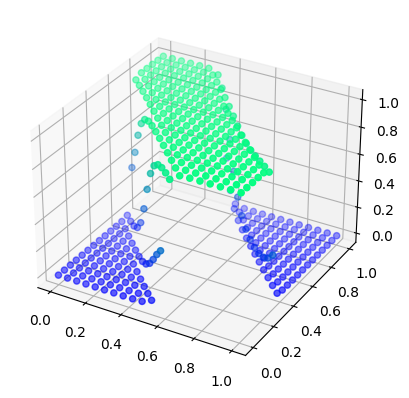

[[0.00107088 0.00107088 0.00107088]]


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

network = [
    Dense(2, 3),
    Tanh(),
    Dense(3, 4),
    Tanh(),
    Dense(4, 2),
    Tanh(),
    Dense(2,1),
    Sigmoid()
]

# train
train(network, binary_cross_entropy, binary_cross_entropy_prime, X, Y, epochs=10000, learning_rate=0.1)

# decision boundary plot
points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = predict(network, [[x], [y]])
        points.append([x, y, z[0,0]])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.show()

print(predict(network, [0,0]))